### CAUTION

**This notebook is not ready for teaching. It's more of an exploration of the topic.**

# Forecasting time series

Start here >> [Pandas_for_time_series](Pandas_for_time_series.ipynb)

In that notebook we build a dataframe from Norwegian production data. At the end, we saved it so that we can read it again here.

In [117]:
import pandas as pd

df = pd.read_csv('npd.csv')

df = df.set_index('ds')

In [118]:
df.head()

,field,water,other,oil,operator
ds,,,,,
2009-07-01,33/9-6 DELTA,0.00051,-0.00004,0.00025,NaN
2009-08-01,33/9-6 DELTA,0.00063,0.00014,0.00325,NaN
2009-09-01,33/9-6 DELTA,0.00316,0.00010,0.00317,NaN
2009-10-01,33/9-6 DELTA,0.00535,0.00012,0.00294,NaN
2009-11-01,33/9-6 DELTA,0.00000,-0.00004,-0.00001,NaN


Let's try to predict water cut.

We'll make a new dataframe just for Troll:

In [198]:
dt = df[df.field=='TROLL'].copy()
dt = dt.drop('field', axis=1)

In [121]:
dt.head()

,water,other,oil,operator
ds,,,,
1990-01-01,0.0,0.0,0.07188,A/S Norske Shell
1990-02-01,0.0,0.0,0.07995,A/S Norske Shell
1990-03-01,0.0,0.0,0.12061,A/S Norske Shell
1990-04-01,0.0,0.0,0.12254,A/S Norske Shell
1990-05-01,0.0,0.0,0.08272,A/S Norske Shell


## ARIMA

[Autoregressive integrated moving average](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

We'll instantiate the model with `order=(5, 1, 0)`. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

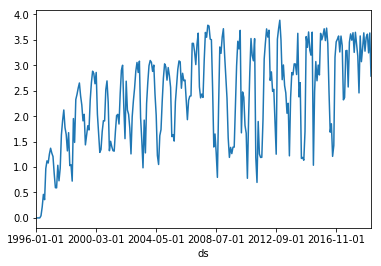

In [127]:
dt.loc['1996':, 'other'].plot()

In [135]:
d_train = dt.loc['1996':'2014', 'other']
d_test = dt.loc['2014':, 'other']

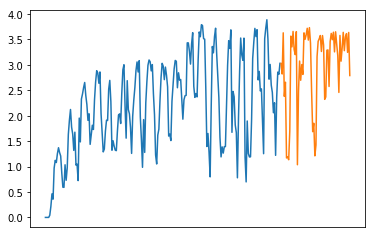

In [141]:
plt.plot(d_train.index, d_train.values)
plt.plot(d_test.index, d_test.values)
plt.xticks([])
plt.show()

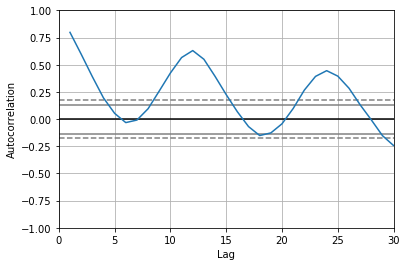

In [143]:
from pandas.plotting import autocorrelation_plot
  
autocorrelation_plot(d_train)
plt.xlim(0, 30)
plt.show()

In [144]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
model = ARIMA(dt.other, order=(4, 1, 0))
model_fit = model.fit(disp=0)
model_fit.summary()

/home/matt/anaconda3/envs/geocomp/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/matt/anaconda3/envs/geocomp/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.

/home/matt/anaconda3/envs/geocomp/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.other   No. Observations:                  351
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -266.932
Method:                       css-mle   S.D. of innovations              0.518
Date:                Thu, 04 Jul 2019   AIC                            545.865
Time:                        09:46:22   BIC                            569.029
Sample:                    02-01-1990   HQIC                           555.084
                         - 04-01-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0084      0.022      0.376      0.707      -0.035       0.052
ar.L1.D.other    -0.0799      0.053     -1.513      0.131      -0.183       0.024
ar.L2.D.other     0.0079      0.053      0.149      0.881      -0.096       0.112
ar.L3.D.other    -0.0083      0.053     -0.157      0.876      -0.112       0.095
ar.L4.D.other    -0.1577      0.053     -2.996      0.003      -0.261      -0.055
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1412           -1.0650j            1.5609           -0.3805
AR.2           -1.1412           +1.0650j            1.5609            0.3805
AR.3            1.1149           -1.1659j            1.6132           -0.1286
AR.4            1.1149           +1.1659j            1.6132            0.1286
-----------------------------------------------------------------------------
"""

Let's look at the residuals.

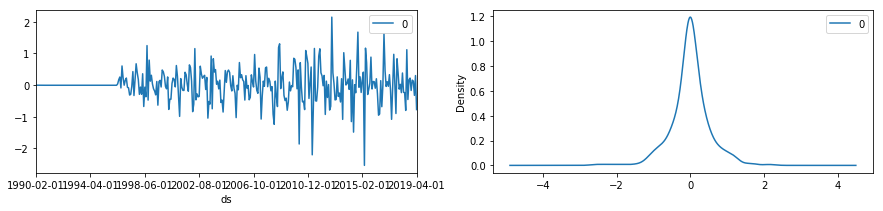

In [145]:
import matplotlib.pyplot as plt

residuals = pd.DataFrame(model_fit.resid)

fig, axs = plt.subplots(figsize=(15, 3), ncols=2)
residuals.plot(ax=axs[0])
residuals.plot(ax=axs[1], kind='kde')
plt.show()

In [146]:
residuals.describe()

,0
count,351.000000
mean,-0.000017
std,0.518314
min,-2.545144
25%,-0.186252
50%,-0.010416
75%,0.215978
max,2.144469


Let's try auto-ARIMA.

Now following this >> https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

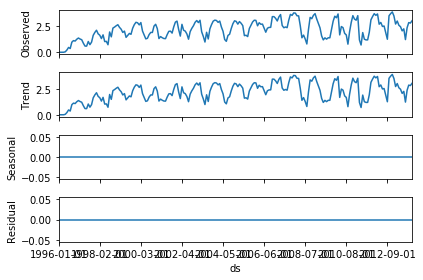

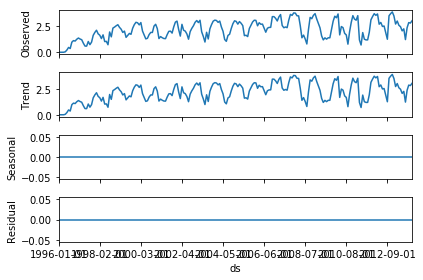

In [158]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(d_train, model='additive', freq=1)

result.plot()

## Forecasting with Facebook prophet

The Prophet API requires a column called `'ds'` for the dates, and another called `'y'` for the thing we want to predict.

In [229]:
dt['y'] = dt['other']

In [230]:
dt.head()

,water,other,oil,operator,y,cap,floor
ds,,,,,,,
1990-01-01,0.0,0.0,0.07188,A/S Norske Shell,0.0,6,0
1990-02-01,0.0,0.0,0.07995,A/S Norske Shell,0.0,6,0
1990-03-01,0.0,0.0,0.12061,A/S Norske Shell,0.0,6,0
1990-04-01,0.0,0.0,0.12254,A/S Norske Shell,0.0,6,0
1990-05-01,0.0,0.0,0.08272,A/S Norske Shell,0.0,6,0


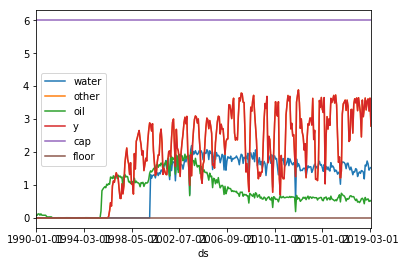

In [231]:
dt.plot()

In [232]:
d_train = dt.loc['1996':'2014'].reset_index()
d_test = dt.loc['2014':].reset_index()

In [233]:
from fbprophet import Prophet

model = Prophet()

model.fit(d_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [234]:
future = model.make_future_dataframe(periods=240, freq='M')

In [235]:
forecast = model.predict(future)

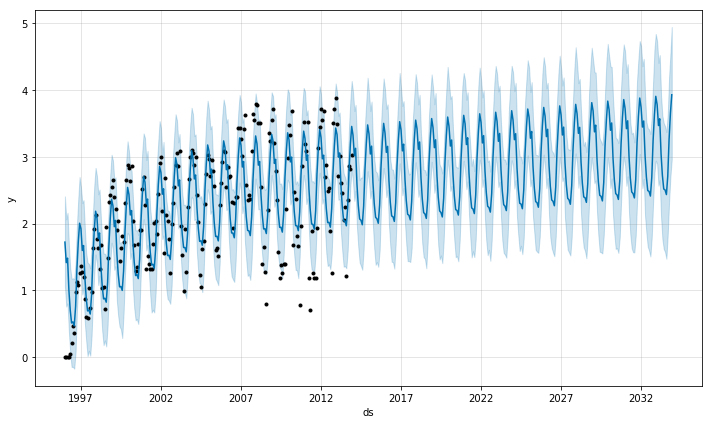

In [236]:
_ = model.plot(forecast)

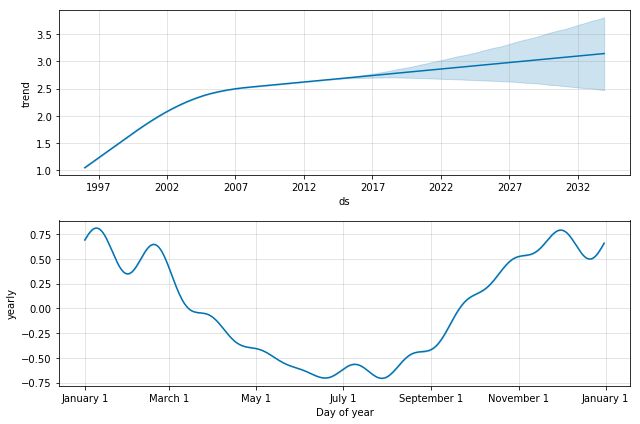

In [237]:
fig = model.plot_components(forecast)

## Check validation data

In [238]:
forecast = model.predict(d_test)

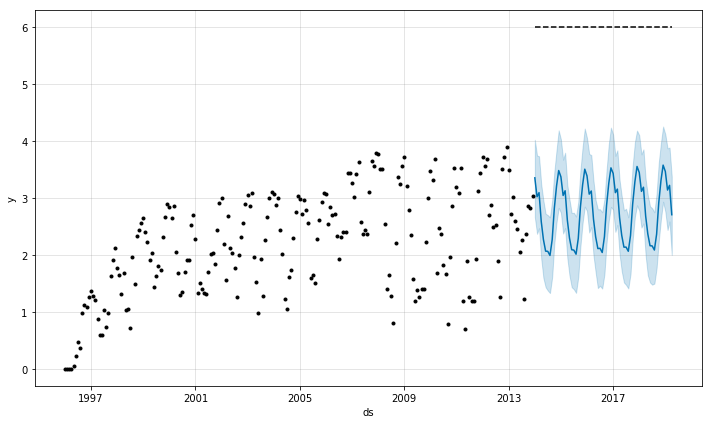

In [239]:
_ = model.plot(forecast)

In [244]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='3600 days', period='90 days', horizon='180 days')
df_cv.head()

INFO:fbprophet:Making 31 forecasts with cutoffs between 2006-01-12 00:00:00 and 2013-06-04 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2006-02-01,2.757605,2.299148,3.274369,2.54928,2006-01-12
1,2006-03-01,2.734515,2.255647,3.230036,2.84354,2006-01-12
2,2006-04-01,2.537087,1.996660,3.067053,2.69761,2006-01-12
3,2006-05-01,2.242588,1.767312,2.741316,2.71122,2006-01-12
4,2006-06-01,1.912806,1.417138,2.386671,2.32915,2006-01-12


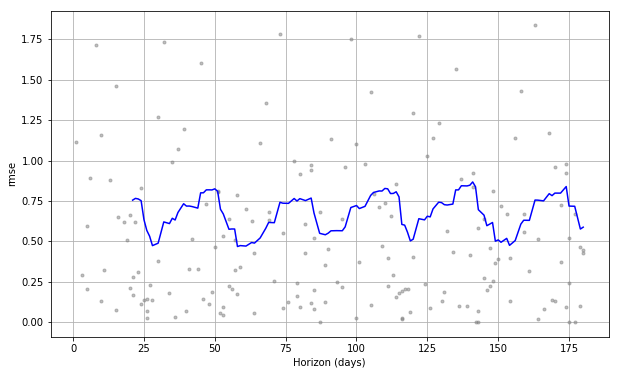

In [246]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

## Logistic growth (with constraints)

Let's look at water:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


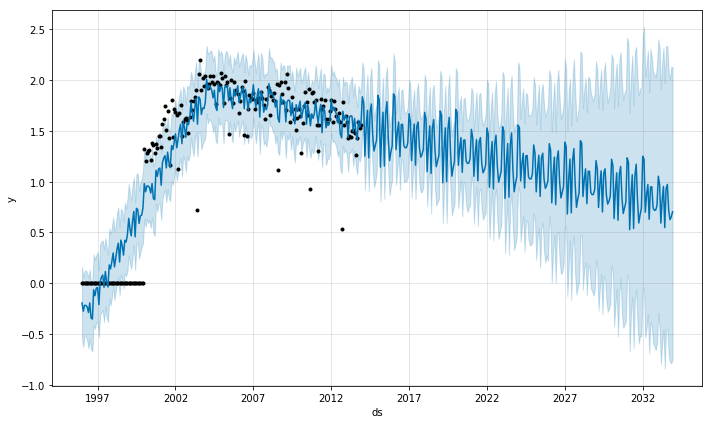

In [219]:
d_train['y'] = d_train['water']

model = Prophet()

model.fit(d_train)

future = model.make_future_dataframe(periods=240, freq='M')

forecast = model.predict(future)

fig = model.plot(forecast)

The model has some predictions going below 0, which is not possible. So let's introduce a constraint.

In [225]:
d_train['cap'] = 3
d_train['floor'] = 0

model = Prophet(growth='logistic')

model.fit(d_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


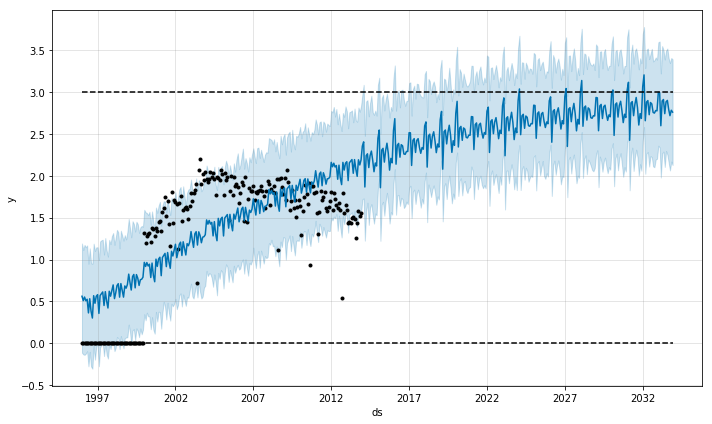

In [226]:
future = model.make_future_dataframe(periods=240, freq='M')
future['cap'] = 3
future['floor'] = 0

forecast = model.predict(future)
fig = model.plot(forecast)

## Controlling the seasonality

The variance is a bit too high; there are ways to control this.

This cell is a little slower to run than the others...

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


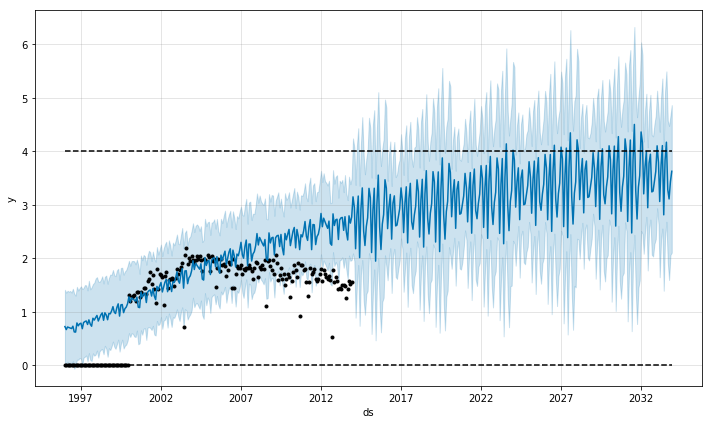

In [228]:
model = Prophet(growth='logistic', seasonality_mode='multiplicative', mcmc_samples=200)

model.fit(d_train)

future = model.make_future_dataframe(periods=240, freq='M')
future['cap'] = 4
future['floor'] = 0

forecast = model.predict(future)

fig = model.plot(forecast)